# PROYECTO FINAL - WBDS LA CAMP ##
**Identificación de secuencias codificantes relacionadas a la producción de biosurfactantes en** ***Bacillus paralicheniformis*** **CPL618** 


## Objetivo: ##
Analizar el genoma *Bacillus paralicheniformis* haciendo la búsqueda de secuencias codificantes y encontrar secuencias homólogas a proteínas asociadas a la producción de biosurfactantes microbianos. 


## Planteamiento del problema: ## 
Los **biosurfactantes** microbianos son un gran número de biomoléculas anfipáticas (con propiedades tanto hidrófilas como hidrófobas), que se han estudiado por sus capacidad de reducción de la tensión superficial y formación de microemulsiones, en las que los hidrocarburos se solubilizan en agua o viceversa. Gracias a sus propiedades únicas, tienen aplicaciones en distintos ámbitos, como la medicina (delivery de fármacos, actividad antiviral y antimicrobiana), la agricultura (tratamiento de semillas, sontrol de patógenos vegetales y biorremediación de suelos) y la industria (aditivos y conservantes de alimentos, detergentes, cosméticos y aplicaciones en la industria petrolera)(Drakontis et al., 2020)(Markande et al., 2021).

En la actualidad está generalizado el uso de surfactantes sintéticos que proceden de la industria petroquímica; sin embargo, su uso es poco sostenible, presentando toxicidad y problemas de biocompatibilidad que dañan los ecosistemas. Los biosurfactantes se consideran un sustituto favorable de sus homólogos sintéticos, ya que pueden ser producidos de forma sostenible y respetuosa con el medio ambiente.Los géneros bacterianos conocidos por la producción de biosurfactantes son *Actinobacteria, Pseudomonas, Sphingomonas, Bacillus, Halomonas, Pseudoalteromonas, Mycobacterium, Alcanivorax, Rhodococcus* y *Arthrobacter* (Kashif et al., 2022). En *Bacillus* se ha reportado la producción de biosurfactantes en tres especies: *Bacillus subtilis, Bacillus amyloliquefaciens* y *Bacillus licheniformis*. En este trabajo se analizará el genoma de *Bacillus paralicheniformis*, especie en la que aún no se ha reportado la producción de estas biomoléculas.



## Metodología: 

**1. Importación de bibliotecas necesarias** (el archivo `credentials.py` contiene el correo electrónico y la API key que proporciona NCBI a sus usuarios registrados):

In [1]:
import credentials
import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import pyrodigal
import requests
import seaborn as sns
import subprocess
import sys
from Bio import SeqIO
from Bio import Entrez
from io                 import StringIO
from matplotlib.patches import Patch
from pycirclize         import Circos
from pycirclize.parser  import Gff
from requests.adapters  import HTTPAdapter, Retry

**2. Obtención de una secuencia genómica**

Se usará el genoma de *Bacillus paralicheniformis* cepa CPL618, específicamente el ensamble ASM2149195v1 y la búsqueda de genes relacionados a la producción de biosurfactantes se hará en el cromosoma con número de acceso **CP090833.1**. A continuación, se descargará el genoma de interés en formato genbank y se almacenará como un objeto de tipo `sequence`:

In [2]:
accession = "CP090833.1"
genome = Entrez.efetch(db="nucleotide",
                       id=accession,
                       format="gb",
                       rettype="text")
record = SeqIO.read(genome, "genbank")


La longitud en bp del genoma descargado:

In [3]:
genome_length = len(record.seq)
genome_length

4447938

**3. Predicción de genes usando pyrodigal**

Se hará la búsqueda de marcos abiertos de lectura en el genoma descargado:

In [4]:
orf_finder = pyrodigal.OrfFinder()
orf_finder.train(bytes(record.seq))
orf_genes  = orf_finder.find_genes(bytes(record.seq))

Con el siguiente código se almacenarán las secuencias aminoacídicas de los genes predichos en un nuevo archivo `CP090833.1.faa`, que luego será útil para comparar las secuencias obtenidas con el set de secuencias de referencia. Se usará "BacParCP" como prefijo del identificador de cada secuencia obtenida:

In [5]:
aa_file = accession + ".faa"
prefix  = "BacParCP"
with open(aa_file, "w") as orf_gene:
    orf_genes.write_translations(orf_gene,sequence_id=prefix)

También almacenaremos las características y coordenadas de los genes predichos en un nuevo archivo `CP090833.1.gff`, que posteriormente nos servirá para visualizar las predicciones realizadas:

In [6]:
gff_file = accession + ".gff"
prefix  = "BacParCP"
with open(gff_file, "w") as orf_gene:
    orf_genes.write_gff(orf_gene,sequence_id=prefix)

**4. Obtención de un set de secuencias de referencia**

Para obtener las secuencias de referencia involucradas en la producción de biosurfactantes se hará uso de la la API de UniProt mediante `requests`. La consulta (query) será la palabra **"biosurfactant"** y también se solicitará que las secuencias tengan el status **"reviewed"**, lo que implica que la secuencia ha sido revisada manualmente:

In [7]:
uniprot_api_url  = "https://rest.uniprot.org/uniprotkb/stream"
uniprot_api_args = {"compressed" : "false",
                    "format"     : "fasta",
                    "query"      : "(biosurfactant) AND (reviewed:true)"}
uniprot_ref_seqs = requests.get(uniprot_api_url,params=uniprot_api_args).text

El siguiente código pasará el objeto `uniprot_ref_seqs` al archivo `uniprot_sequences.fasta`:

In [8]:
uniprot_seqs_file = open("uniprot_sequences.fasta", "wt")
uniprot_seqs_file.write(uniprot_ref_seqs)
uniprot_seqs_file.close()

**5. Uso de BLAST para la comparación de secuencias**

Primero, se construirá manualmente un comando que `subprocess` ejecutará fuera del entorno de python. Es importante indicar adecuadamente el path en el que se encuentra instalado el programa `makeblastdb`. Este comando crea una base de datos a partir de el archivo `CP090833.1.faa`:

In [9]:
makeblastdb_path = "/Program Files/NCBI/blast-2.9.0+/bin/makeblastdb" #Path de programa makeblastdb instalado previamente en PC
makeblastdb_command = [makeblastdb_path,'-in',aa_file,'-dbtype','prot']
subprocess.call(makeblastdb_command)

0

A continuación se hará uso del programa `blastp` usando como query o consulta las secuencias de referencia `uniprot_sequences.fasta` y como base de datos la creada en el anterior paso usando las secuencias codificantes del genoma estudiado (`CP090833.1.faa`), tomando en cuenta un e-value de 1e-6. Se especificará que el archivo de salida esté en formato `.tsv`. De la misma manera, se ejecutará el comando a través de `subprocess`:

In [10]:
blastp_path       = "/Program Files/NCBI/blast-2.9.0+/bin/blastp" #Path de programa blastp instalado previamente en PC
blastp_out_format = "6 qseqid sseqid qlen slen qstart sstart qend send score evalue length positive"
blastp_out_file   = accession + ".blast.tsv"
blastp_command    = [blastp_path,
                     "-db",          aa_file,
                     "-query",       "uniprot_sequences.fasta",
                     "-evalue",      "1e-6",
                     "-out",         blastp_out_file,
                     "-outfmt",      blastp_out_format,
                     "-num_threads", "12"]
subprocess.call(blastp_command)

0

Los resultados de BLAST están en el archivo `CP090833.1.blast.tsv`, pero esta tabla no contiene los nombres de las columnas. A continuación, se importará esta tabla a un dataframe de pandas, asignándole los nombres de las columnas usando la variable `blastp_out_format` definida anteriormente:

In [11]:
blastp_column_names = blastp_out_format.split(" ")[1:]
blastp_df = pd.read_csv(blastp_out_file,sep="\t",names=blastp_column_names)
blastp_df

,qseqid,sseqid,qlen,slen,qstart,sstart,qend,send,score,evalue,length,positive
0,sp|B8QHP1|CP52M_STABO,BacParCP_1557,538,1075,104,52,536,450,324,1.920000e-32,449,199
1,sp|B8QHP1|CP52M_STABO,BacParCP_2463,538,407,326,223,514,383,135,1.550000e-09,194,84
2,sp|P39135|SFP_BACSU,BacParCP_3679,224,227,1,1,223,223,698,1.420000e-94,223,162
3,sp|P54292|RHLR_PSEAE,BacParCP_3197,241,201,177,138,239,198,106,6.990000e-07,63,35
4,sp|A0A0D1DMJ7|CYP1_USTMA,BacParCP_1557,640,1075,226,79,596,427,178,2.850000e-14,379,161
...,...,...,...,...,...,...,...,...,...,...,...,...
952,sp|P9WER8|MALA_MORAP,BacParCP_1886,7760,158,2923,6,3070,142,123,1.100000e-07,148,64
953,sp|E7CQW6|UGTA1_STABO,BacParCP_4166,463,398,265,222,414,369,117,1.840000e-07,150,68
954,sp|E7CQW6|UGTA1_STABO,BacParCP_3810,463,405,225,190,435,391,114,4.910000e-07,212,91
955,sp|E9L011|UGTB1_STABO,BacParCP_4166,432,398,260,222,405,364,136,9.120000e-10,146,69


De manera **complementaria** al análisis BLAST hecho en los pasos anteriores, es recomendabe repetir el proceso, pero esta vez usando las secuencias de referencia `uniprot_sequences.fasta` como base de datos. De esta manera se filtran mejor los resultados, descartanto los hits que solo se dieron en uno de los análisis.

Se repetirá el proceso, haciendo uso de `subprocess` para ejecutar el comando en `makeblast` y crear una base de datos a partir del archivo `uniprot_sequences.fasta`:

In [12]:
makeblastdb_path = "/Program Files/NCBI/blast-2.9.0+/bin/makeblastdb" #Path de programa makeblastdb instalado previamente en PC
makeblastdb_command = [makeblastdb_path,'-in',"uniprot_sequences.fasta",'-dbtype','prot']
subprocess.call(makeblastdb_command)

0

De la misma manera, se correrá `blastp` usando la base de datos creada en el paso anterior y el archivo `CP090833.1.faa` como consulta. El e-value será de 1e-6:

In [13]:
blastp_path      = "/Program Files/NCBI/blast-2.9.0+/bin/blastp" #Path de programa blastp instalado previamente en PC
blast_out_format = "6 qseqid sseqid qlen slen qstart sstart qend send score evalue length positive"
blast_out_file   = "uniprot_sequences.blast.tsv"
blastp_command   = [blastp_path,
                    "-db",          "uniprot_sequences.fasta",
                    "-query",       aa_file,
                    "-evalue",      "1e-6",
                    "-out",         blast_out_file,
                    "-outfmt",      blast_out_format,
                    "-num_threads", "12"]
subprocess.call(blastp_command)

0

Por último, se volverá a crear un dataframe con pandas a partir del archivo `uniprot_sequences.blast.tsv` usando la variable `blast_out_format` y asignando los nombres correspondientes a las columnas:

In [14]:
blastp_column_names = blast_out_format.split(" ")[1:]
blastp_rev_df = pd.read_csv(blast_out_file,sep="\t",names=blastp_column_names)
blastp_rev_df

,qseqid,sseqid,qlen,slen,qstart,sstart,qend,send,score,evalue,length,positive
0,BacParCP_21,sp|H6TB12|MDR_STABO,333,1299,22,1068,245,1281,202,1.290000e-19,233,116
1,BacParCP_21,sp|H6TB12|MDR_STABO,333,1299,29,415,285,673,188,7.660000e-18,281,137
2,BacParCP_21,sp|A0A0D1BUH6|ATR1_USTMA,333,1382,28,1157,247,1367,181,6.380000e-17,224,111
3,BacParCP_21,sp|A0A0D1BUH6|ATR1_USTMA,333,1382,37,475,258,689,177,1.670000e-16,231,105
4,BacParCP_28,sp|H6TB12|MDR_STABO,338,1299,2,386,254,638,210,1.240000e-20,272,126
...,...,...,...,...,...,...,...,...,...,...,...,...
1032,BacParCP_4602,sp|H6TB12|MDR_STABO,308,1299,22,1068,240,1282,194,7.910000e-19,231,111
1033,BacParCP_4602,sp|H6TB12|MDR_STABO,308,1299,6,393,253,638,178,1.050000e-16,265,125
1034,BacParCP_4681,sp|G0YF19|SAT_STABO,193,259,6,42,184,229,377,1.300000e-47,188,107
1035,BacParCP_4691,sp|A0A0D1DYJ6|MMF1_USTMA,475,619,9,87,348,435,186,3.840000e-17,350,176


Los dataframes resultantes de ambos análisis BLAST complementarios se encuentran en las variables **`blastp_df`** (análisis blastp usando el archivo `uniprot_sequences.fasta` como query y el archivo `CP090833.1.faa` como base de datos) y **`blastp_rev_df`** (análisis blastp usando el archivo `CP090833.1.faa` como query y el archivo `uniprot_sequences.fasta` como base de datos).

A continuación, se hará uso de pandas para obtener un solo dataframe consenso, para ello se agregará la columna **'both'** en **`blast_df`** que asignará un booleano dependiendo si el valor de la columna **'sseqid'** (identificador de secuencias del genoma de interés) también se encuentra en la columna **'qseqid'** de **`blastp_rev_df`**:

In [15]:
blastp_df['both'] = blastp_rev_df.qseqid.isin(blastp_df.sseqid)
blastp_df

,qseqid,sseqid,qlen,slen,qstart,sstart,qend,send,score,evalue,length,positive,both
0,sp|B8QHP1|CP52M_STABO,BacParCP_1557,538,1075,104,52,536,450,324,1.920000e-32,449,199,True
1,sp|B8QHP1|CP52M_STABO,BacParCP_2463,538,407,326,223,514,383,135,1.550000e-09,194,84,True
2,sp|P39135|SFP_BACSU,BacParCP_3679,224,227,1,1,223,223,698,1.420000e-94,223,162,True
3,sp|P54292|RHLR_PSEAE,BacParCP_3197,241,201,177,138,239,198,106,6.990000e-07,63,35,True
4,sp|A0A0D1DMJ7|CYP1_USTMA,BacParCP_1557,640,1075,226,79,596,427,178,2.850000e-14,379,161,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
952,sp|P9WER8|MALA_MORAP,BacParCP_1886,7760,158,2923,6,3070,142,123,1.100000e-07,148,64,True
953,sp|E7CQW6|UGTA1_STABO,BacParCP_4166,463,398,265,222,414,369,117,1.840000e-07,150,68,True
954,sp|E7CQW6|UGTA1_STABO,BacParCP_3810,463,405,225,190,435,391,114,4.910000e-07,212,91,True
955,sp|E9L011|UGTB1_STABO,BacParCP_4166,432,398,260,222,405,364,136,9.120000e-10,146,69,True


El codigo siguiente indicará la cantidad de secuencias que coinciden en ambos dataframes, es decir tienen *True* en la columna **'both'**:

In [16]:
print(blastp_df['both'].value_counts())

True     932
False     25
Name: both, dtype: int64


Se creará un dataframe consenso (**`blastp_cons_df`**) a partir de las columnas que se repiten en ambos análisis:

In [17]:
blastp_cons_df = blastp_df.drop(blastp_df[blastp_df['both']==False].index)


El siguiente código permite contar cuantas secuencias únicas o genes candidatos existen en el dataframe consenso:

In [18]:
candidate_genes=blastp_cons_df["sseqid"].unique().tolist()
len(candidate_genes)
print('Genes candidatos resultantes de BLAST:'+' '+str(len(candidate_genes)))

Genes candidatos resultantes de BLAST: 153


**6. Visualización de datos obtenidos:**

**6.1 Visualización de los genes de interés en el genoma bacteriano usando `pycirclize`**

Para hacer una visualización preliminar de los datos obtenidos y así filtrar mejor las secuencias de interés obtenidas se hará uso de `pycirclize` que tomará un archivo `.gff` para dibujar el genoma, resaltando las secuencias obtenidas como genes candidatos.

Primero se construirá un dataframe a partir del archivo `CP090833.1.gff` obtenido anteriormente y que contiene las coordenadas de los genes predichos por `pyrodigal`. Al construir el dataframe se le asignarán los nombres a las columnas, contenidos en la lista `gff_columns`; además se indicará que las columnas **'start'** y **'end'** serán de tipo *int*, es decir valores numéricos:

In [19]:
gff_columns     = ["chr","source","feature_type","start","end","score","strand","phase","info"]
gff_df          = pd.read_csv(gff_file,sep="\t",comment="#",header=None,names=gff_columns)
gff_df["start"] = gff_df["start"].astype(int)
gff_df["end"]   = gff_df["end"].astype(int)
gff_df

,chr,source,feature_type,start,end,score,strand,phase,info
0,BacParCP,pyrodigal_v2.1.0,CDS,2,1069,113.1,+,0,ID=BacParCP_1;partial=10;start_type=Edge;rbs_m...
1,BacParCP,pyrodigal_v2.1.0,CDS,1137,3023,227.8,+,0,ID=BacParCP_2;partial=00;start_type=ATG;rbs_mo...
2,BacParCP,pyrodigal_v2.1.0,CDS,3146,3505,35.6,+,0,ID=BacParCP_3;partial=00;start_type=ATG;rbs_mo...
3,BacParCP,pyrodigal_v2.1.0,CDS,3502,4137,57.0,+,0,ID=BacParCP_4;partial=00;start_type=TTG;rbs_mo...
4,BacParCP,pyrodigal_v2.1.0,CDS,4153,4797,84.1,+,0,ID=BacParCP_5;partial=00;start_type=ATG;rbs_mo...
...,...,...,...,...,...,...,...,...,...
4755,BacParCP,pyrodigal_v2.1.0,CDS,4444100,4444792,44.7,+,0,ID=BacParCP_4756;partial=00;start_type=GTG;rbs...
4756,BacParCP,pyrodigal_v2.1.0,CDS,4444807,4445418,74.5,+,0,ID=BacParCP_4757;partial=00;start_type=ATG;rbs...
4757,BacParCP,pyrodigal_v2.1.0,CDS,4445598,4447466,215.8,+,0,ID=BacParCP_4758;partial=00;start_type=ATG;rbs...
4758,BacParCP,pyrodigal_v2.1.0,CDS,4447487,4447765,15.6,+,0,ID=BacParCP_4759;partial=00;start_type=ATG;rbs...


A continuación se reducirá el dataframe generado a partir del archivo `.gff`, ya que este contiene todas las secuencias codificantes del genoma y para visualizar la generado por este analísis se requieren solo las secuencias de los genes de interés.

Para ello, primero se definirá la función `get_gff_info`, que creará un diccionario que irá llenándose con partes de la información contenida en texto en la columna **'info'**:

In [20]:
def get_gff_info(info_str):
    out_dict = {}
    info_arr = info_str.split(";")
    for line in info_arr:
        if "=" in line:
            line_arr    = line.split("=")
            field_name  = line_arr[0]
            field_value = line_arr[1]
            out_dict[field_name] = field_value
    return out_dict

A continuación, se hará uso de la función `apply` de pandas para transformar la columna **'info'** con la función `get_gff_info` recientemente definida y así crear la nueva columna **'annotation'**:

In [21]:
gff_df["annotation"] = gff_df["info"].apply(lambda x: get_gff_info(x))

La transformación anterior permitirá extraer información específica de la columna **'info'** que incluye el ID de la secuencia. Con el siguiente código se creará la columna **'candidate'** que resultará de la transformación de la columna **'annotation** con la condición de que si el ID correspondiente también se encuentra en la lista `candidate_genes` se agregará la palabra *include* en la columna **'candidate'**, de lo contrario tendrá la palabra *exclude*:

In [22]:
gff_df["candidate"] = gff_df["annotation"].apply(lambda x: "include" if x["ID"] in candidate_genes else "exclude")

Luego, se creará un nuevo dataframe `candidate_df` a partir de la copia del dataframe `gff_df`, en este solo se incluirán las filas que tengan la palabra *include* en la columna **'candidate'**. También se guardará el dataframe en el archivo `candidates.gff` que será usado para graficar en `pycirclize`:

In [23]:
candidate_df = gff_df.copy()
candidate_df = candidate_df[candidate_df["candidate"]=="include"][gff_columns]
candidate_df.to_csv("candidates.gff",sep="\t",header=False,index=False)

Por último, se graficará la distribución de los genes de interés en el genoma de *Bacillus paralicheniformis* usando `pycirclize`. Se tomará en cuenta la longitud del genoma específico (`genome_lenght`) y se usará el archivo `candidates.gff` que contiene solo los genes de interés. En cuanto a las carácterísticas del gráfico, en **rojo** de observarán los genes codificados en la cadena positiva y en **azul** los codificados en la cadena negativa:

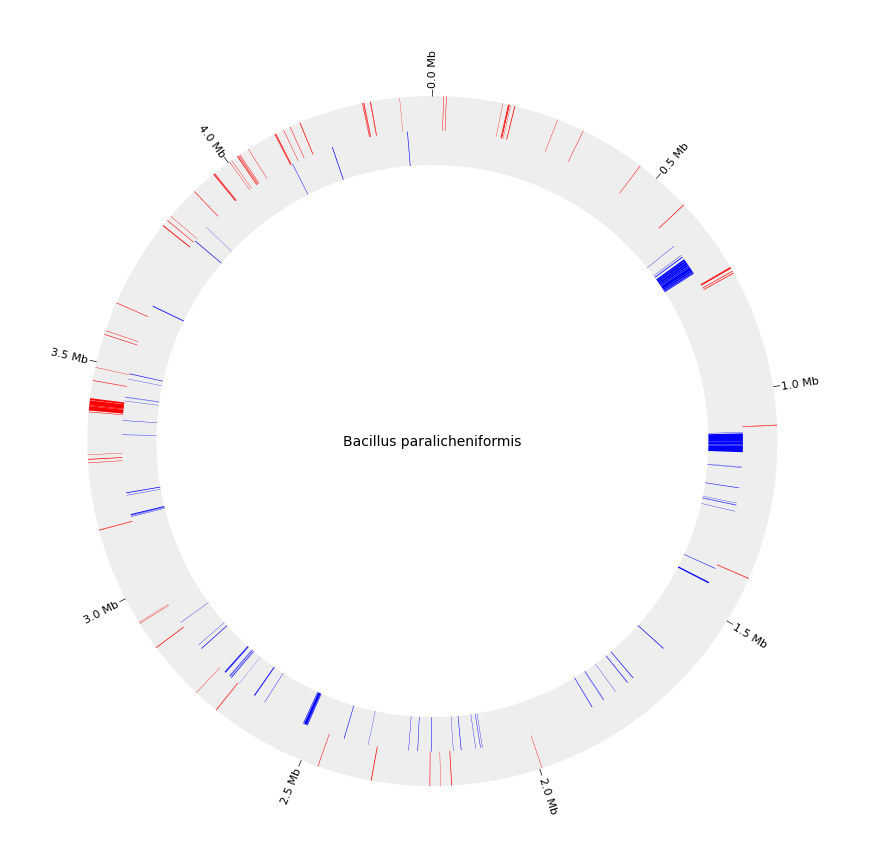

In [25]:
circos = Circos(sectors={accession: genome_length})
circos.text("Bacillus paralicheniformis")
circos_gff = Gff(gff_file="candidates.gff")
sector = circos.get_sector(accession)
sector = circos.sectors[0]
cds_track = sector.add_track((80, 100))
cds_track.axis(fc="#EEEEEE", ec="none")
cds_track.genomic_features(circos_gff.extract_features("CDS", target_strand =  1), r_lim=(90, 100),fc="red" )
cds_track.genomic_features(circos_gff.extract_features("CDS", target_strand = -1), r_lim=(80,  90),fc="blue")
pos_list, labels = [], []
cds_track.xticks_by_interval(
    interval=500000,
    label_formatter=lambda label_value: f"{label_value/ 1000000:.1f} Mb",
    label_orientation="vertical")
circos.savefig('Cromosoma-GenesInteres.png')

Algo importante a tomar en cuenta al observar el gráfico generado por `pycirclize` es la presencia de operones en los genomas bacterianos. Un **operón** es una unidad genética funcional, que incluye a un grupo de genes bajo control de un solo promotor. Estos genes generalmente están involucrados en las mismas funciones metabólicas y se encuentran ubicados consecutivamente en el cromosoma bacteriano. 

Conociendo lo anterior y observando el gráfico generado, los genes de interés que se encuentran particualrmente agrupados podrían pertenecer a un mismo operón, confirmando que  potencialmente están involucrados en la misma ruta metabólica, en este caso la producción de biomoléculas biosurfactantes.

**6.2 Visualización de los datos con seaborn**

Para una examinación más exhaustiva de los potenciales operones, se graficarán 25 swarmplots para comparar las posiciones de los genes en el dataframe completo, separando por categorias ("genes candidatos" vs "genes no candidatos") y por cadena ("+" vs "-"). Especificando en el eje Y si son genes candidatos o no (*include* o *exclude*) y en el eje X las coordenadas de inicio. Al igual que en el gráfico anterior, en **rojo** se observarán los genes codificados en la cadena positiva y en **azul** los codificados en la cadena negativa:

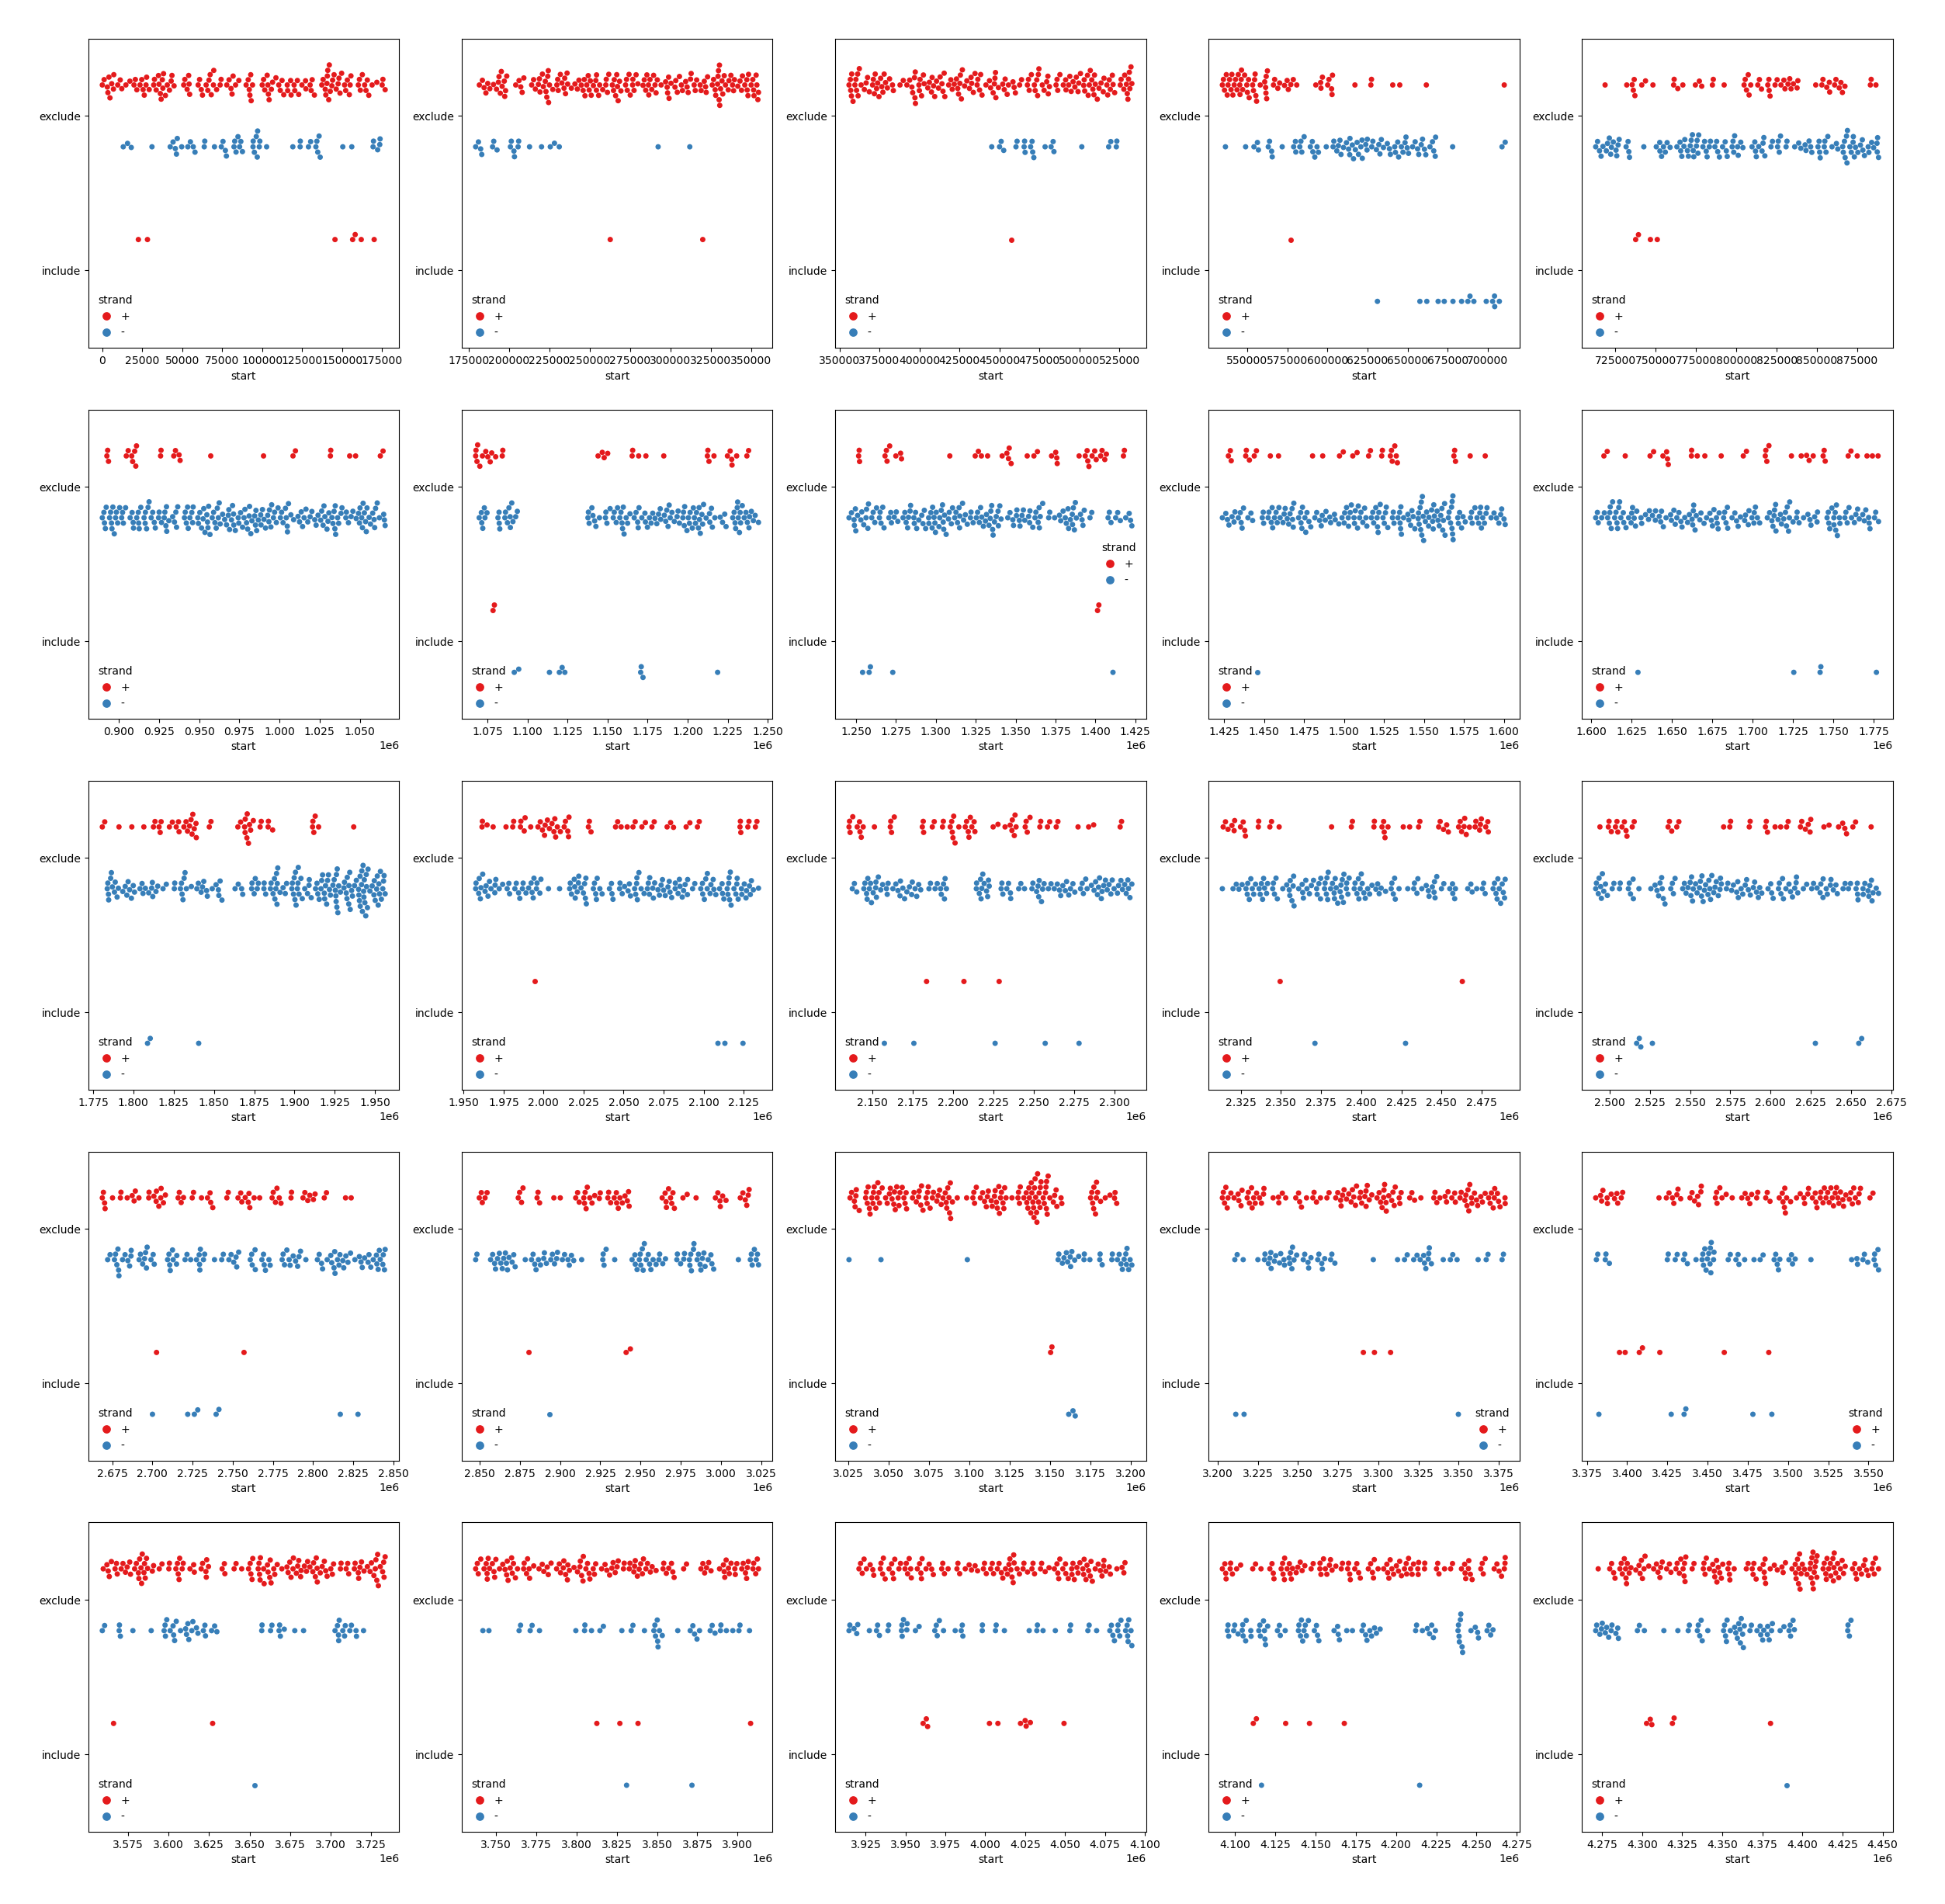

<Figure size 640x480 with 0 Axes>

In [26]:
num_bins = 25
counter_1 = 0
counter_2 = 0
fig, axes = plt.subplots(5,5,figsize=(30,30))
bin_len  = (genome_length - (genome_length % (num_bins - 1))) / (num_bins)
for bin_num in range(num_bins):
    start_pos = bin_num * bin_len
    end_pos   = (bin_num + 1) * bin_len
    mb_df = gff_df.copy()
    mb_df = mb_df[(mb_df["start"]>start_pos) & (mb_df["end"]<=end_pos)]
    sns.swarmplot(ax = axes[counter_1,counter_2],data = mb_df,y="candidate",x="start",hue="strand",dodge=True,palette = 'Set1',order=["exclude","include"],hue_order=["+","-"])
    axes[counter_1,counter_2].set(ylabel=None)
    counter_2 += 1
    if (counter_2%5 == 0):
        counter_2 = 0
        counter_1 += 1
plt.show()
plt.savefig('Swarmplots_operones.png')

Al observar con más detalle la distribución de los genes, se podría proponer la existencia de un operón ubicado en la cadena negativa, aproximadamente entre 0.65 Mbp y 0.725 Mbp

**7. Examinación a detalle del operón seleccionado y sus dominios funcionales**

En primer lugar, se generará un nuevo dataframe a partir del dataframe `gff_df` y se indicará que este solo incluya a los genes que se encuentran dentro de las coordenadas del operón seleccionado (0.65 Mbp y 0.725 Mbp), que estén en la cadena negativa y que además sean parte de los genes de interés, es decir, que presenten el valor *include* en la columna **'candidate'**:

In [27]:
operon_df = gff_df.copy()
operon_df = operon_df[(operon_df["start"]     >= 650000) &
                      (operon_df["end"]       <= 725000) &
                      (operon_df["strand"]    == "-")     &
                      (operon_df["candidate"] == "include")]
operon_df.reset_index(drop=True, inplace=True)

In [28]:
print('Cantidad de genes candidatos en operón seleccionado:'+' '+str(len(operon_df)))

Cantidad de genes candidatos en operón seleccionado: 14


A continuación se agregarán a la lista `operon_gene_list` los identificadores de los 14 genes pertenecientes al operón seleccionado:

In [29]:
operon_gene_list = []
for index in operon_df.index.tolist():
    gene_id = operon_df["annotation"][index]["ID"]
    operon_gene_list.append(gene_id)

Se construirá un set de secuencias en formato FASTA que servirá de query al hacer un análisis de las secuencias de interés en el servicio web de `InterProScan`. Esto se logrará usando la biblioteca de `Biopython` llamada `SeqIO`, indicando que por cada ID presente en la lista `operon_gene_list`, se agregue su correspondiente secuencia aminoacídica y esta información sea adicionada a la variable `query_str`:

In [30]:
query_str = ""
for record in SeqIO.parse(aa_file, "fasta"):
    seq_id  = record.id
    if(seq_id in operon_gene_list):
        seq_str = str(record.seq)
        query_str+=">"+seq_id+"\n"+seq_str+"\n"
query_str = query_str.replace("*","")

El proceso de búsqueda de dominios se hará a través de la API de `InterProScan`, a continuación se crearán tres variables con una URL correspondiente, que representan los siguientes procesos:

`submit_url`: Envío de las secuencias

`progress_url`: Consulta del status del envío

`results_url`: Descarga de resultados

In [31]:
submit_url   = "https://www.ebi.ac.uk/Tools/services/rest/iprscan5/run"
progress_url = "https://www.ebi.ac.uk/Tools/services/rest/iprscan5/status"
results_url  = "https://www.ebi.ac.uk/Tools/services/rest/iprscan5/result"

Se agregarán a las variables recientemente creadas, diccionarios que contengan qué tipo de encabezados son permitidos para poder interactuar con la API de `InterProScan`:

In [32]:
submit_headers   = {"Accept":"text/plain"}
progress_headers = {"Accept":"text/plain"}
results_headers  = {"Accept":"text/tab-separated-values"}

En esta etapa, se construirá un diccionario de python que se adjuntará a `requests` para buscar los dominios funcionales de interés. Este diccionario incluirá el correo personal, el título del trabajo y las secuencias query (`query_str`):

In [33]:
submit_data = {"email":"andrea.pacheco@gmail.com", #Cambiar por correo personal para hacer seguimiento de resultados
               "title":"operon_065_0725",
               "goterms":"false",
               "pathways":"false",
               "stype":"p",
               "sequence":query_str}

Haciendo uso del protocolo `post`, se pasará el diccionario creado a `request`, y se mandará la información a la URL de envío de secuencias `submit_url`:

In [34]:
submit_request = requests.post(submit_url,data=submit_data,headers=submit_headers)

Con el siguiente código se obtendrá el código de estado y el `job_id` pertenecientes al trabajo enviado a `InterProScan`:

In [34]:
submit_status_code = submit_request.status_code
submit_job_id      = submit_request.text
print(submit_status_code)
print(submit_job_id)

200
iprscan5-R20230317-004939-0038-41840473-p1m


Se podrá hacer la consulta del envío realizado usando el `job_id` correspondiente y la variable `progress_url` definida anteriormente, usando el protocolo `get` de `request`, de la siguiente manera:


In [35]:
progress_request     = requests.get(progress_url+"/"+'iprscan5-R20230317-004939-0038-41840473-p1m',headers=progress_headers)
progress_status_code = progress_request.status_code
progress_status      = progress_request.text
print(progress_status_code)
print(progress_status)

200
FINISHED


Una vez que la variable `progress_status` imprima la palabra **FINISHED** se podrá observar el resultado del análisis de dominios funcionales en `InterProScan`. Los archivos resultantes son de tipo `log` y `tsv`, se crearán las variables `results_log_request` y `results_tsv_request` para acceder al reporte de texto del programa y para acceder al reporte tabular programa correspondientemente. Para ello se emplerá el protocolo `get` de `request`, usando la variable `results_url` creada anteriormente:

In [36]:
results_log_request = requests.get(results_url+"/"+'iprscan5-R20230317-004939-0038-41840473-p1m'+"/log",headers=results_headers)
results_tsv_request = requests.get(results_url+"/"+'iprscan5-R20230317-004939-0038-41840473-p1m'+"/tsv",headers=results_headers)

Finalmente, se examinarán los resultados obtenidos del análisis, para ello se usará la biblioteca `StringIO` para incorporar los resultados que se encuentran en la variable `results_tsv_request` a un nuevo dataframe, agregándole los nombres de las columnas correspondientes pertenecientes a la lista `results_column_names`:

In [37]:
results_tsv_str = StringIO(results_tsv_request.text)
results_column_names = ["sequence","md5","length","database","accession","description","start","end","evalue","post_processed","date","entry","name"]
results_df = pd.read_csv(results_tsv_str,sep="\t",names=results_column_names)
results_df

,sequence,md5,length,database,accession,description,start,end,evalue,post_processed,date,entry,name
0,BacParCP_729,463000f3d5a5f50d4b1f9f64cad742c3,650,Gene3D,G3DSA:3.40.50.12780,-,14,519,1.7E-154,T,17-03-2023,IPR042099,"ANL, N-terminal domain"
1,BacParCP_729,463000f3d5a5f50d4b1f9f64cad742c3,650,Pfam,PF16177,Acetyl-coenzyme A synthetase N-terminus,31,85,3.9E-11,T,17-03-2023,IPR032387,"Acetyl-coenzyme A synthetase, N-terminal domain"
2,BacParCP_729,463000f3d5a5f50d4b1f9f64cad742c3,650,SUPERFAMILY,SSF56801,Acetyl-CoA synthetase-like,19,641,4.45E-158,T,17-03-2023,-,-
3,BacParCP_729,463000f3d5a5f50d4b1f9f64cad742c3,650,Pfam,PF00501,AMP-binding enzyme,99,524,1.9E-77,T,17-03-2023,IPR000873,AMP-dependent synthetase/ligase domain
4,BacParCP_729,463000f3d5a5f50d4b1f9f64cad742c3,650,ProSitePatterns,PS00455,Putative AMP-binding domain signature.,266,277,-,T,17-03-2023,IPR020845,"AMP-binding, conserved site"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,BacParCP_744,061787ef234302669d65bdf19609bd8f,416,Gene3D,G3DSA:3.30.300.30,-,51,145,8.4E-32,T,17-03-2023,IPR045851,"AMP-binding enzyme, C-terminal domain superfamily"
336,BacParCP_744,061787ef234302669d65bdf19609bd8f,416,SUPERFAMILY,SSF47336,ACP-like,151,224,3.02E-18,T,17-03-2023,IPR036736,ACP-like superfamily
337,BacParCP_745,ef2f17835f465cce92399a034ae01798,56,Pfam,PF00501,AMP-binding enzyme,5,46,4.2E-9,T,17-03-2023,IPR000873,AMP-dependent synthetase/ligase domain
338,BacParCP_745,ef2f17835f465cce92399a034ae01798,56,Gene3D,G3DSA:2.30.38.10,Luciferase; Domain 3,3,54,2.9E-13,T,17-03-2023,-,-


A continuación, se hará un análisis general de los dominios funcionales más presentes en el set de datos generado por `InterProScan`. Se tomarán en cuenta dos columnas:

**'description'**: Esta columna contiene los dominios hallados por alguna de las 13 bases de datos pertenecientes al `InterPro consortium`

**'name:'** Esta columna contiene información de los nombres de los dominios funcionales consenso encontrados por `InterPro`.

Primero se realizará un gráfico de barras de los dominios más frecuentes en la columna **'description'** del dataframe, para ello se generará un nuevo dataframe `results_df_description` que excluirá las filas que no contienen información (contienen el caracter "-"). Luego se hará un conteo de los valores presentes en la columna y se generará un gráfico de barras horizontal a partir de este conteo:

<AxesSubplot:>

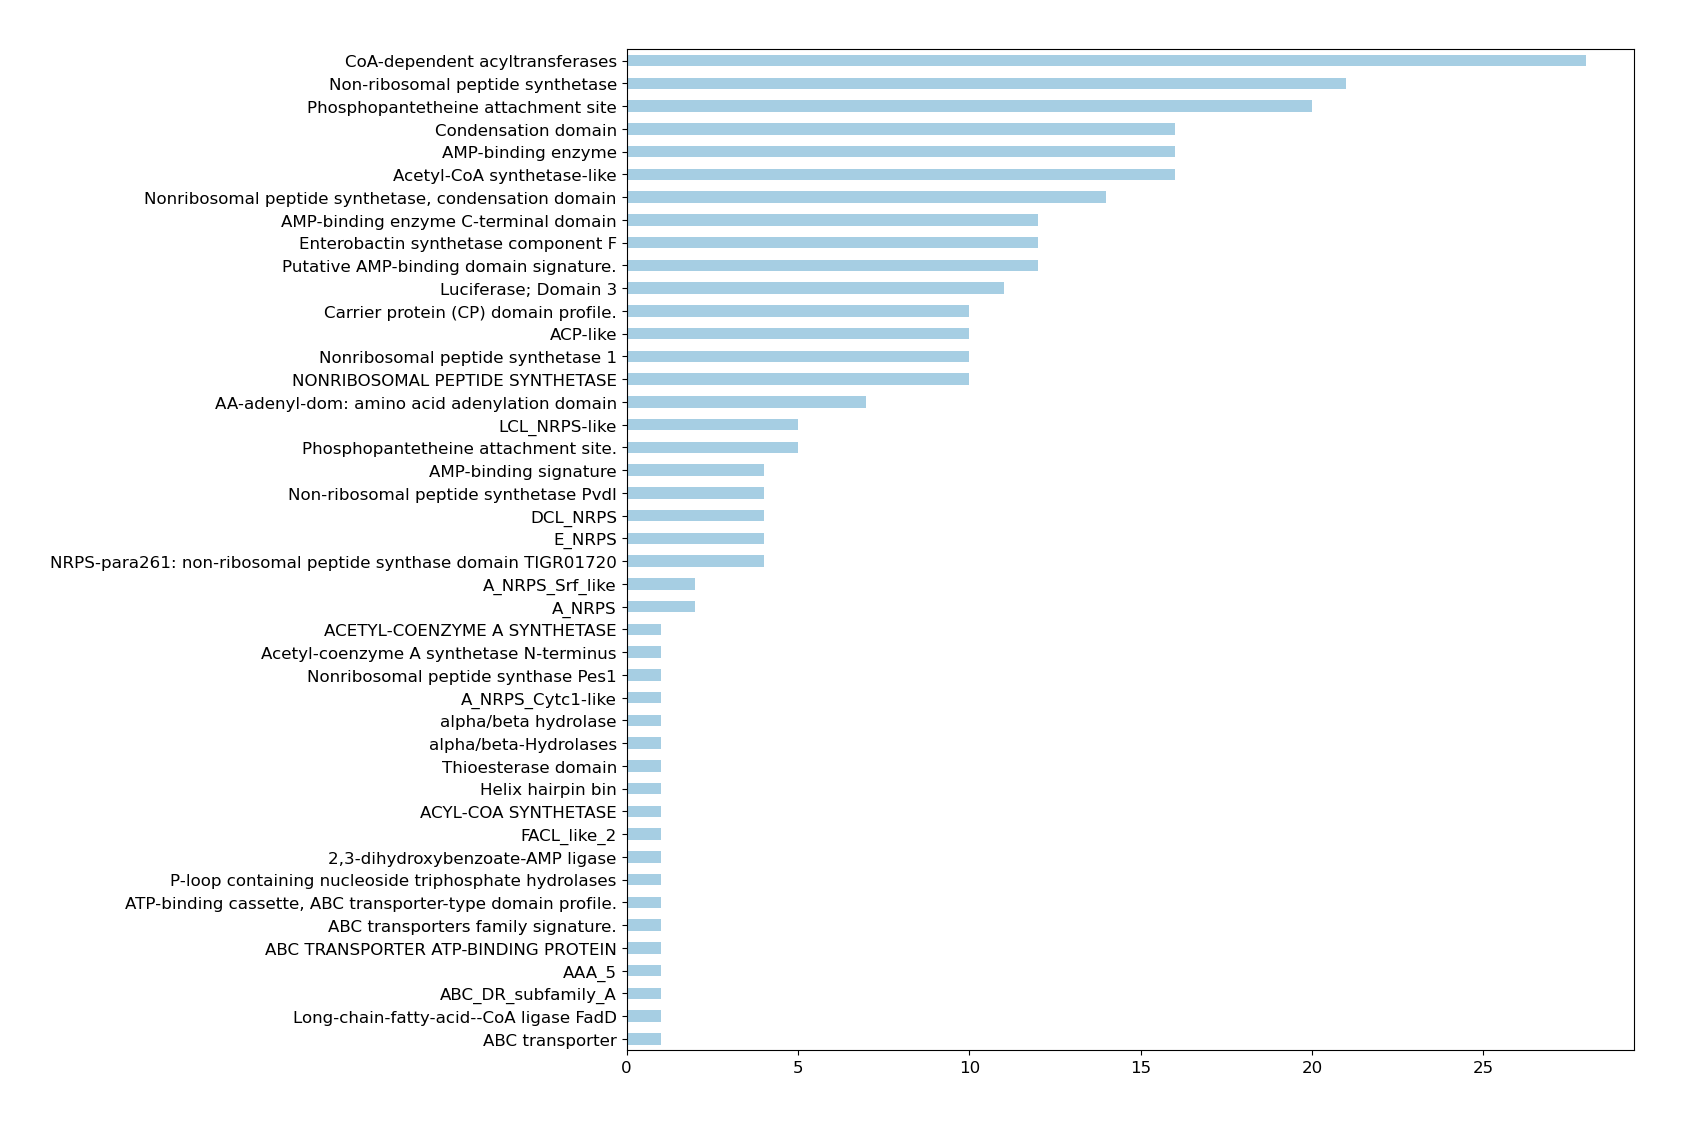

In [38]:
results_df_description = results_df[results_df['description'] != '-']
results_df_description.description.value_counts().sort_values().plot(kind='barh', fontsize=12,figsize=(13,13),colormap='Paired' )

Luego se generará un gráfico de barras de los dominios más frecuentes en la columna **'name'** del dataframe, para ello se generará un nuevo dataframe `results_df_name` que excluirá las filas que no contienen información (contienen el caracter "-"). Por útimo, se hará un conteo de los valores presentes en la columna y se generará un gráfico de barras horizontal a partir de este conteo:

<AxesSubplot:>

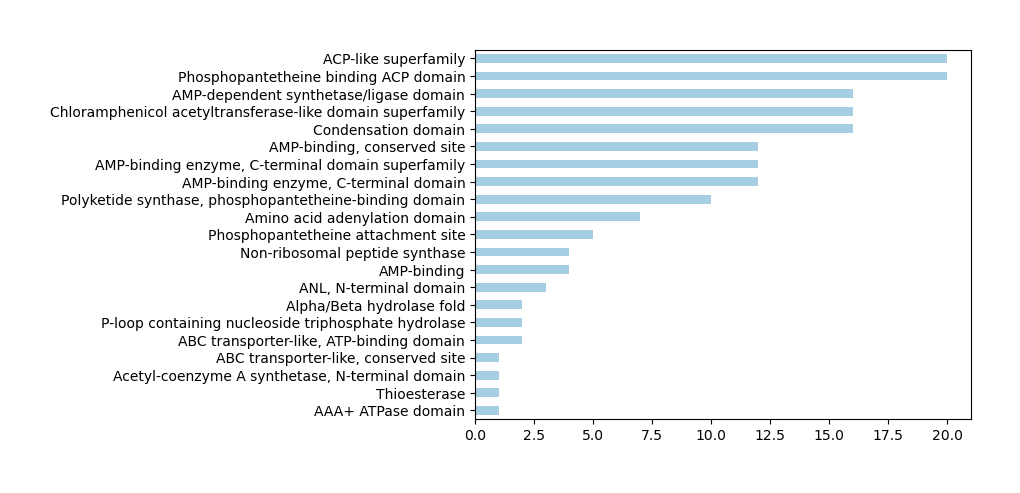

In [39]:
results_df_name = results_df[results_df['name'] != '-']
results_df_name.name.value_counts().sort_values().plot(kind='barh',colormap='Paired')

In [41]:
dominio_description = (results_df_description['description'].mode()).tolist()
dominio_name = (results_df_name['name'].mode()).tolist()
print('Los dominios funcionales más frecuentes en las secuencias seleccionadas son:')
for x in range (len(dominio_description)):
    print(dominio_description[x])
for j in range (len(dominio_name)):
    print(dominio_name[j])

Los dominios funcionales más frecuentes en las secuencias seleccionadas son:
CoA-dependent acyltransferases
ACP-like superfamily
Phosphopantetheine binding ACP domain


Los dominios funcionales más frecuentes en el análisis generado por `InterProScan` fueron: **coa-dependent acyltransferases**, **ACP-like superfamily** y **Phosphopantetheine binding ACP domain**. 
En general, los tres dominios están involucrados en el metabolismo de lípidos, al hacer una búsqueda manual por texto de los tres dominios en la web de `InterProScan`, se obtiene información de la función de cada uno de ellos: 
- Las proteinas con dominio coa-dependent acyltransferases están involucradas en la oxidación de ácidos grasos. 
- La proteína transportadora de acilo (ACP) es un cofactor esencial en la síntesis de ácidos grasos por los sistemas de sintetasas de ácidos grasos en bacterias y plantas, además de la síntesis de ácidos grasos, la ACP también participa en muchas otras reacciones que requieren pasos de transferencia de acilo, como la síntesis de antibióticos policétidos, precursores de biotina y oligosacáridos derivados de membranas.
- La fosfopanteteína es el grupo prostético de las proteínas transportadoras de acilo (ACP) en algunos complejos multienzimáticos donde sirve de "brazo oscilante" para la unión de grupos de ácidos grasos y aminoácidos activados.

Al hacer una búsqueda bibliográfica, se encuentra que dentro de los tipos de biosurfactantes microbianos se encuentra la **surfactina**, un lipopéptido antibacteriano producido por diferentes cepas de *Bacillus subtilis*, este es un potente biosurfactante con múltiples actividades biológicas, como antiviral, antimicoplasma y antiprotozoaria, además de actividades antimicrobianas de amplio espectro contra bacterias Gram-positivas, bacterias Gram-negativas y hongos (Chen et al., 2022). Los dominios funcionales encontrados en las secuencias de interés seleccionadas en este trabajo estarían involucrados en la biosíntesis de surfactina en *Bacillus subtilis* (Mootz et al., 2001), por lo que se podría proponer que las secuencias seleccionadas en este trabajo pertenecerían un operón involucrado en la biosintesis de un homólogo de surfactina en *Bacillus paralicheniformis*. 

## Conclusiones: ##
- El trabajo realizado permitió analizar un genoma completo ensamblado pero no anotado de *Bacillus paralicheniformis* encontrado en NCBI.
- Se logró predecir secuencias codificantes en dicho genoma.
- Se comparó las secuencias codificantes halladas con secuencias de referencia asociadas a la producción de biosurfactantes microbianos extraídas de UniProt. Esto permitió seleccionar secuencias del genoma de *Bacillus paralicheniformis* candidatas a estar relacionadas a la producción de biosurfactantes.
- Una exploración de la ubicación de estas secuencias en el cromosoma bacteriano permitió proponer el hallazgo de un operón relacionado a la producción de las biomoléculas de interés
- La búsqueda de los dominios funcionales de las secuencias pertenecientes a este candidato a operón y el contraste con bibliografía permitió proponer que se podría tratar de un operón involucrado en la biosintesis de un homólogo de surfactina en *Bacillus paralicheniformis*

## Bibliografía: ##
- Chen, X., Lu, Y., Shan, M., Zhao, H., Lu, Z., & Lu, Y. (2022). A mini-review: Mechanism of antimicrobial action and application of surfactin. World Journal of Microbiology and Biotechnology, 38(8), 143.
- Drakontis, C. E., & Amin, S. (2020). Biosurfactants: Formulations, properties, and applications. Current Opinion in Colloid & Interface Science, 48, 77-90.
- Kashif, A., Rehman, R., Fuwad, A., Shahid, M. K., Dayarathne, H. N. P., Jamal, A., ... & Choi, Y. (2022). Current advances in the classification, production, properties and applications of microbial biosurfactants–A critical review. Advances in Colloid and Interface Science, 102718.
- Markande, A. R., Patel, D., & Varjani, S. (2021). A review on biosurfactants: properties, applications and current developments. Bioresource Technology, 330, 124963.
- Mootz, H. D., Finking, R., & Marahiel, M. A. (2001). 4′-Phosphopantetheine transfer in primary and secondary metabolism of Bacillus subtilis. Journal of Biological Chemistry, 276(40), 37289-37298.